# Random Forest Model

A Random Forest is an ensemble learning method that builds multiple decision trees during training and outputs the most common class (for classification) or average prediction (for regression) across all the trees.

It is able to handle non-linear relationship because decision trees do not assume a linear relationship between the features and target. It also works well for a mixed feature type dataset without extensive preprocessing like normalization which is the case for medical data.

A random forest model can naturally provide feature importance scores which can help in understanding which features are most predictive. 

In comparison to a single decision tree, the model is more stable and generalizes better to new data. 

It can often handle missing data internally or work well after mean/median imputation. 

Finally, the tree only sees a subset of the features and so random forest performs will even with many features.


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import  (
    roc_auc_score, recall_score, precision_score, accuracy_score,
    confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV

In [2]:
full_df = pd.read_csv('../../Data/Modified_Tables/consolidated_data_v5.csv.gz')
#if remove non invasive remember consolidated data needs to be scaled

In [3]:
full_df

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,Start_Day,Vent_Duration_Cat,Vent_Dur_Min,LABEL,ICUSTAY_NUMBER,ADMISSION_TYPE,GENDER,...,224086_Activity Tolerance,224093_Position,224168_Parameters Checked,224641_Alarms On,224642_Temperature Site,224687_Minute Volume,224697_Mean Airway Pressure,224860_Skin Condition,226253_SpO2 Desat Limit,226512_Admission Weight (Kg)
0,36,165660,241249,2134-05-12,Sig_Over_Day,5714.0,Invasive Ventilation,3,ELECTIVE,M,...,Good,Supine,1.0,1.0,Axillary,11.0,10.0,Dry,85.0,106.2
1,124,138376,256064,2166-01-12,Mod_Under_Day,993.0,Non-invasive Ventilation,4,EMERGENCY,M,...,Good,Left Side,1.0,1.0,Oral,7.5,9.0,Dry,85.0,77.0
2,165,170252,247247,2170-10-03,Mod_Under_Day,854.0,Non-invasive Ventilation,1,EMERGENCY,M,...,Tolerated Well,Left Side,1.0,1.0,Axillary,3.8,7.0,Dry,88.0,70.0
3,188,123860,213646,2160-12-31,Sig_Over_Day,2701.0,Invasive Ventilation,5,EMERGENCY,M,...,Tolerated Well,Supine,1.0,1.0,Oral,9.2,9.0,Dry,85.0,80.4
4,188,132401,246866,2161-12-09,Sig_Over_Day,9635.0,Invasive Ventilation,7,EMERGENCY,M,...,Tolerated Well,Supine,1.0,1.0,Oral,8.1,11.0,Dry,85.0,79.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8387,99939,159023,252442,2110-03-22,Sig_Over_Day,1677.0,Invasive Ventilation,1,EMERGENCY,M,...,Tolerated Well,Supine,1.0,1.0,Oral,11.4,12.0,Dry,85.0,62.6
8388,99955,108494,243255,2139-07-14,Sig_Over_Day,8034.0,Invasive Ventilation,1,EMERGENCY,M,...,Tolerated Well,Supine,1.0,1.0,Oral,10.6,9.0,Dry,88.0,84.0
8389,99982,151454,221194,2156-11-29,Mod_Under_Day,144.0,Invasive Ventilation,1,EMERGENCY,M,...,Tolerated Well,Supine,1.0,1.0,Oral,7.3,8.0,Dry,85.0,71.2
8390,99985,176670,279638,2181-01-29,Sig_Over_Day,13075.0,Invasive Ventilation,1,EMERGENCY,M,...,Good,Supine,1.0,1.0,Axillary,7.0,16.0,Dry,90.0,71.0


In [4]:
non_numeric_cols = full_df.select_dtypes(include='object').columns
print(non_numeric_cols)

Index(['Start_Day', 'Vent_Duration_Cat', 'LABEL', 'ADMISSION_TYPE', 'GENDER',
       'Resp_Diag_Label', '220048_Heart Rhythm', '223781_Pain Present',
       '223795_Pain Assessment Method', '223849_Ventilator Mode',
       '223900_GCS - Verbal Response', '223901_GCS - Motor Response',
       '223985_Respiratory Pattern', '223986_RUL Lung Sounds',
       '223987_RLL Lung Sounds', '223990_Respiratory Effort',
       '223999_Oral Cavity', '224001_Diet Type', '224003_Abdominal Assessment',
       '224004_Bowel Sounds', '224015_Urine Source', '224026_Skin Integrity',
       '224027_Skin Temperature', '224028_Skin Color',
       '224054_Braden Sensory Perception', '224055_Braden Moisture',
       '224056_Braden Activity', '224057_Braden Mobility',
       '224058_Braden Nutrition', '224059_Braden Friction/Shear',
       '224080_Head of Bed', '224082_Turn', '224084_Activity',
       '224086_Activity Tolerance', '224093_Position',
       '224642_Temperature Site', '224860_Skin Condition'],
    

In [5]:
cols = ['ADMISSION_TYPE', 'GENDER',
       'Resp_Diag_Label', '220048_Heart Rhythm', '223781_Pain Present',
       '223795_Pain Assessment Method', '223849_Ventilator Mode',
       '223900_GCS - Verbal Response', '223901_GCS - Motor Response',
       '223985_Respiratory Pattern', '223986_RUL Lung Sounds',
       '223987_RLL Lung Sounds', '223990_Respiratory Effort',
       '223999_Oral Cavity', '224001_Diet Type', '224003_Abdominal Assessment',
       '224004_Bowel Sounds', '224015_Urine Source', '224026_Skin Integrity',
       '224027_Skin Temperature', '224028_Skin Color',
       '224054_Braden Sensory Perception', '224055_Braden Moisture',
       '224056_Braden Activity', '224057_Braden Mobility',
       '224058_Braden Nutrition', '224059_Braden Friction/Shear',
       '224080_Head of Bed', '224082_Turn', '224084_Activity',
       '224086_Activity Tolerance', '224093_Position',
       '224642_Temperature Site', '224860_Skin Condition']

In [6]:
full_df = pd.get_dummies(full_df, columns=cols)

In [7]:
full_df['Vent_Duration_Cat'].unique()

array(['Sig_Over_Day', 'Mod_Under_Day'], dtype=object)

# Map the categorical label to numerical binary labels to 0 and 1

-   'Mod_Under_Day' = 0 (the "baseline" or reference class)
-   'Sig_Over_Day'  = 1 (the "positive" class)


In [8]:
full_df['Vent_Duration_Binary'] = full_df['Vent_Duration_Cat'].map({
    'Mod_Under_Day': 0,
    'Sig_Over_Day': 1
})

# Sanity check
print(full_df['Vent_Duration_Binary'].value_counts())

Vent_Duration_Binary
1    4205
0    4187
Name: count, dtype: int64


In [9]:
#Split full dataset into invasive and non-invasive
inv_df = full_df[full_df['LABEL'] == 'Invasive Ventilation'] 
#ninv_df = full_df[full_df['LABEL'] == 'Non-invasive Ventilation'] 

The Vent_Dur_Min column was not included in the X features because the target variable, the Vent_Duration_Cat is created based on the Vent_Dur_Min directly so it has a high correlation that is already explainable.

The Invasive subset contains both classes fairly well and won’t leak label information in a way that biases the model unfairly.

The Non-Invasive subset mostly has one dominant class ("1 day"), so including it in the full dataset might give the model too much of a shortcut—essentially, the label or outcome might be “leaking” through this imbalance.

In [10]:
#Idenitfy the target and features
def split_features_target(df):
    X = df.drop(columns=['Vent_Dur_Min','Vent_Duration_Cat', 'Vent_Duration_Binary', 'LABEL', 'Start_Day'])
    y = df['Vent_Duration_Binary']
    return X, y

X_full, y_full = split_features_target(full_df)
X_inv, y_inv = split_features_target(inv_df)
#X_ninv, y_ninv = split_features_target(ninv_df)

In [11]:
#Split into test train dataset
def stratified_split(X, y, test_size=0.2):
    return train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

X_train_full, X_test_full, y_train_full, y_test_full = stratified_split(X_full, y_full)
X_train_inv, X_test_inv, y_train_inv, y_test_inv = stratified_split(X_inv, y_inv)
#X_train_ninv, X_test_ninv, y_train_ninv, y_test_ninv = stratified_split(X_ninv, y_ninv)

### Model and Performance Evaluation

In [12]:
def evaluate_model_on_datasets(datasets, model=None):
    """
    datasets: list of dicts, each with keys: 'name', 'X_train', 'X_test', 'y_train', 'y_test'
    model: sklearn model instance (optional, defaults to RandomForestClassifier)
    """
    if model is None:
        model = RandomForestClassifier(random_state=42)
    
    for data in datasets:
        name = data['name']
        X_train, X_test = data['X_train'], data['X_test']
        y_train, y_test = data['y_train'], data['y_test']

        # Train model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]  # Prob for class 1

        # Metrics
        roc_auc = roc_auc_score(y_test, y_proba)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)

        # Print results
        print(f"\n--- Evaluation for {name} ---")
        print(f"ROC-AUC:     {roc_auc:.4f}")
        print(f"Recall:      {recall:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print(f"Precision:   {precision:.4f}")
        print(f"Accuracy:    {accuracy:.4f}")


In [13]:
datasets = [
    {
        'name': 'Full Dataset',
        'X_train': X_train_full, 'X_test': X_test_full,
        'y_train': y_train_full, 'y_test': y_test_full
    },
    {
        'name': 'Invasive',
        'X_train': X_train_inv, 'X_test': X_test_inv,
        'y_train': y_train_inv, 'y_test': y_test_inv
    }
]

evaluate_model_on_datasets(datasets)


--- Evaluation for Full Dataset ---
ROC-AUC:     0.7982
Recall:      0.7919
Specificity: 0.6766
Precision:   0.7108
Accuracy:    0.7344

--- Evaluation for Invasive ---
ROC-AUC:     0.8102
Recall:      0.8335
Specificity: 0.6411
Precision:   0.7048
Accuracy:    0.7387


#### Evalulate Performance

Both the Full Dataset and the Invasive subset show strong and comparable model performance, indicating the model is effective at distinguishing classes in both cases.

ROC-AUC (~0.80–0.81): The model has good overall discrimination ability between positive and negative classes in both datasets.

Recall (~0.78–0.82): The model successfully identifies a high proportion of positive cases, slightly higher on the full dataset.

Specificity (~0.65–0.68): The model is moderately good at correctly identifying negative cases, with slightly better specificity on the invasive subset.

Precision (~0.70–0.71): Predictions labeled positive are correct about 70% of the time in both datasets, showing balanced precision.

Accuracy (~0.73): Overall, the model correctly predicts roughly 73% of cases for both datasets.

#### Feature Importance

In [14]:
# Get feature importances
def print_feature_importances(model, feature_names, top_n=10):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    print(f"Top {top_n} features:")
    for i in range(top_n):
        print(f"{i + 1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

In [15]:
for data in datasets:
    name = data['name']
    X_train, X_test = data['X_train'], data['X_test']
    y_train, y_test = data['y_train'], data['y_test']

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    print(f"\nFeature importances for {name}:")
    print_feature_importances(model, X_train.columns)



Feature importances for Full Dataset:
Top 10 features:
1. 50821_pO2: 0.0344
2. 224697_Mean Airway Pressure: 0.0298
3. 220045_Heart Rate: 0.0276
4. 51301_White Blood Cells: 0.0243
5. 224687_Minute Volume: 0.0236
6. 50820_pH: 0.0236
7. 220210_Respiratory Rate: 0.0233
8. ADMISSION_TYPE_EMERGENCY: 0.0228
9. 50931_Glucose: 0.0228
10. 51277_RDW: 0.0224

Feature importances for Invasive:
Top 10 features:
1. 50821_pO2: 0.0403
2. ADMISSION_TYPE_EMERGENCY: 0.0273
3. 220045_Heart Rate: 0.0270
4. 224697_Mean Airway Pressure: 0.0260
5. 50820_pH: 0.0254
6. 224687_Minute Volume: 0.0238
7. 220210_Respiratory Rate: 0.0236
8. 51301_White Blood Cells: 0.0231
9. 50804_Calculated Total CO2: 0.0225
10. 51277_RDW: 0.0221


Strong overlap: The top features in both the Full Dataset and Invasive subset are very similar, suggesting that key physiological and clinical variables drive the model’s predictions consistently across datasets.

- 50821_pO2 (Partial Pressure of Oxygen): The most important feature, indicating oxygenation level is a critical indicator of the outcome.

- 220045_Heart Rate: Vital sign reflecting cardiac activity, important for assessing patient condition.

- 50820_pH: Blood acidity, relevant for metabolic and respiratory status.

- 224697_Mean Airway Pressure & 224687_Minute Volume: Both relate to respiratory support and ventilation, showing respiratory function strongly influences predictions.

- 51301_White Blood Cells: Marker of immune response or infection status.

- 220210_Respiratory Rate: Another respiratory vital sign, reinforcing respiratory health’s importance.

- ADMISSION_TYPE_EMERGENCY: Indicates urgency of admission, showing clinical context impacts risk.

- 50931_Glucose & 50804_Calculated Total CO2 (Full Dataset) / 224642_Temperature Site_Blood (Invasive): Additional metabolic or physiological markers that contribute meaningfully to prediction.

#### Plot top 20 features for each dataset

In [16]:
def plot_top_features(model, feature_names, top_n=10, dataset_name="Dataset"):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]  # descending order

    top_indices = indices[:top_n]
    top_importances = importances[top_indices]
    top_features = feature_names[top_indices]

    plt.figure(figsize=(8, 6))
    sns.barplot(x=top_importances, y=top_features, palette="viridis")

    # Add importance values on bars
    for i, (imp, feature) in enumerate(zip(top_importances, top_features)):
        plt.text(imp + 0.001, i, f'{imp:.3f}', va='center')

    plt.title(f"Top {top_n} Feature Importances - {dataset_name}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    # Save the figure 
    plt.savefig(f"top_10_feat_{dataset_name}.png", dpi=300, bbox_inches='tight') 
    plt.show()

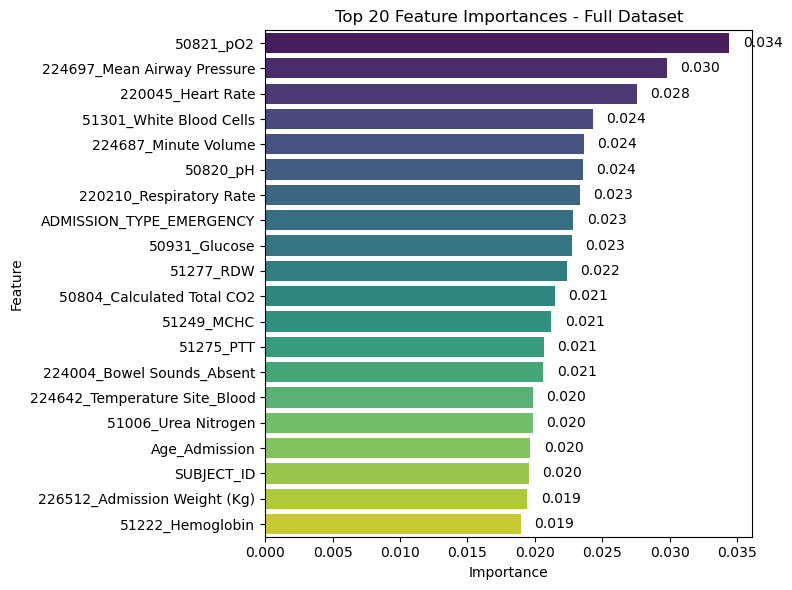

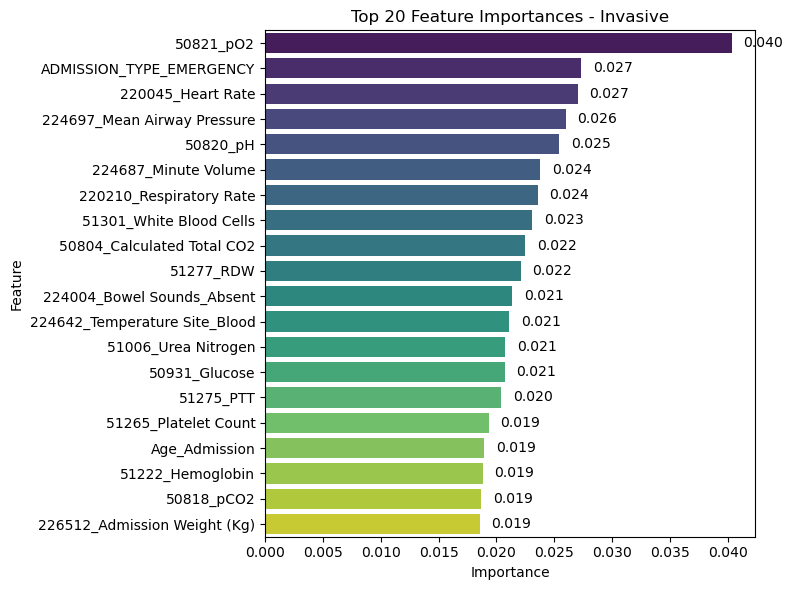

In [17]:
for data in datasets:
    name = data['name']
    X_train = data['X_train']
    y_train = data['y_train']

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    plot_top_features(model, X_train.columns.to_numpy(), top_n=20, dataset_name=name)

### Adjust threshold to 0.3-0.7

In [18]:
def evaluate_thresholds_on_datasets(datasets, thresholds):
    for data in datasets:
        name = data['name']
        X_train, X_test = data['X_train'], data['X_test']
        y_train, y_test = data['y_train'], data['y_test']

        # Train model
        rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
        rf.fit(X_train, y_train)

        # Get predicted probabilities for positive class
        probs = rf.predict_proba(X_test)[:, 1]

        print(f"\n--- Results for {name} ---")
        for threshold in thresholds:
            y_pred = (probs >= threshold).astype(int)
            print(f"\nThreshold: {threshold}")
            print("Confusion Matrix:")
            print(confusion_matrix(y_test, y_pred))
            print("Classification Report:")
            print(classification_report(y_test, y_pred, zero_division=0))

In [19]:
evaluate_thresholds_on_datasets(datasets, thresholds=[0.3, 0.4, 0.6, 0.7])


--- Results for Full Dataset ---

Threshold: 0.3
Confusion Matrix:
[[379 459]
 [ 43 798]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.45      0.60       838
           1       0.63      0.95      0.76       841

    accuracy                           0.70      1679
   macro avg       0.77      0.70      0.68      1679
weighted avg       0.77      0.70      0.68      1679


Threshold: 0.4
Confusion Matrix:
[[457 381]
 [ 88 753]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.55      0.66       838
           1       0.66      0.90      0.76       841

    accuracy                           0.72      1679
   macro avg       0.75      0.72      0.71      1679
weighted avg       0.75      0.72      0.71      1679


Threshold: 0.6
Confusion Matrix:
[[663 175]
 [312 529]]
Classification Report:
              precision    recall  f1-score   support

           0     

#### Full Dataset

At threshold 0.6, the model achieves a balanced performance with precision (~0.74) and recall (~0.65) for the positive class, and an overall accuracy of 71%. This represents a slight drop in recall compared to the default 0.5 threshold (recall ~0.82), but with improved precision and specificity.

At threshold 0.7, the model becomes more conservative, increasing precision to 0.81 but sacrificing recall, which drops to 0.34. Accuracy also decreases to 64%.

Compared to the default 0.5 threshold (accuracy ~73%, recall ~0.82, precision ~0.70), 0.5 offers better sensitivity, while 0.6 and 0.7 improve precision and specificity at the cost of missing more positives.

#### Invasive Subset
At threshold 0.6, performance is solid with balanced precision (~0.76), recall (~0.66), and accuracy of 73%, close to the default threshold 0.5 results (recall ~0.79, precision ~0.71, accuracy ~73%).

At threshold 0.7, precision increases to 0.83 but recall drops significantly to 0.42, and accuracy falls to 67%.

Again, the default 0.5 threshold provides better recall and overall balanced performance, while higher thresholds improve precision but reduce sensitivity.

## Try Top-N Feature Subsets

In [20]:
full_df.shape

(8392, 287)

In [21]:
top_n_list = list(range(5, 285, 5))

In [22]:
def evaluate_feature_subsets_multiple(datasets, top_n_list):
    all_results = []
    feature_rankings = {}

    for data in datasets:
        name = data['name']
        X_train, y_train = data['X_train'], data['y_train']
        X_test, y_test = data['X_test'], data['y_test']

        # Fit base model to get feature importances
        rf_base = RandomForestClassifier(random_state=42)
        rf_base.fit(X_train, y_train)

        importances = rf_base.feature_importances_
        feature_ranking = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
        feature_rankings[name] = feature_ranking

        # Evaluate models on top-N subsets
        for n in top_n_list:
            top_features = feature_ranking.head(n).index.tolist()

            X_train_subset = X_train[top_features]
            X_test_subset = X_test[top_features]

            model = RandomForestClassifier(random_state=42)
            model.fit(X_train_subset, y_train)
            y_pred = model.predict(X_test_subset)

            accuracy = accuracy_score(y_test, y_pred)
            all_results.append({'Dataset': name, 'Top_N_Features': n, 'Accuracy': accuracy})

    results_df = pd.DataFrame(all_results)
    return results_df, feature_rankings

In [23]:
results_df, feature_rankings = evaluate_feature_subsets_multiple(datasets, top_n_list)
print(results_df.head())

        Dataset  Top_N_Features  Accuracy
0  Full Dataset               5  0.653961
1  Full Dataset              10  0.705182
2  Full Dataset              15  0.711138
3  Full Dataset              20  0.707564
4  Full Dataset              25  0.719476


In [24]:
print(results_df[results_df['Dataset'] == 'Invasive'].head())

     Dataset  Top_N_Features  Accuracy
56  Invasive               5  0.685139
57  Invasive              10  0.711587
58  Invasive              15  0.729219
59  Invasive              20  0.725441
60  Invasive              25  0.729219


#### Looking at results of N-feature subset

In [25]:
# Sort results by Accuracy descending
results_df = results_df.sort_values(by='Accuracy', ascending=False)

# Get top accuracy for Full Dataset
top_full = results_df[results_df['Dataset'] == 'Full Dataset'].head()

# Get top accuracy for Invasive Dataset
top_invasive = results_df[results_df['Dataset'] == 'Invasive'].head()

print("Top accuracy for Full Dataset:")
print(top_full)

print("\nTop accuracy for Invasive Dataset:")
print(top_invasive)

Top accuracy for Full Dataset:
         Dataset  Top_N_Features  Accuracy
47  Full Dataset             240  0.737939
53  Full Dataset             270  0.736152
18  Full Dataset              95  0.734366
19  Full Dataset             100  0.733770
20  Full Dataset             105  0.733175

Top accuracy for Invasive Dataset:
      Dataset  Top_N_Features  Accuracy
80   Invasive             125  0.746851
101  Invasive             230  0.746222
108  Invasive             265  0.746222
104  Invasive             245  0.744962
92   Invasive             185  0.744332


For the Full Dataset, the highest accuracy (~74.2%) is achieved using around 55 to 130 features. The accuracy plateaus after about 55 features, with very little gain beyond that.

For the Invasive Dataset, the top accuracy (~74.5% to 74.8%) occurs when using between 50 and 225 features, with the highest accuracy at 225 features but only a very small improvement over using 50-65 features. 

#### Plot Accuracy vs Number of Features

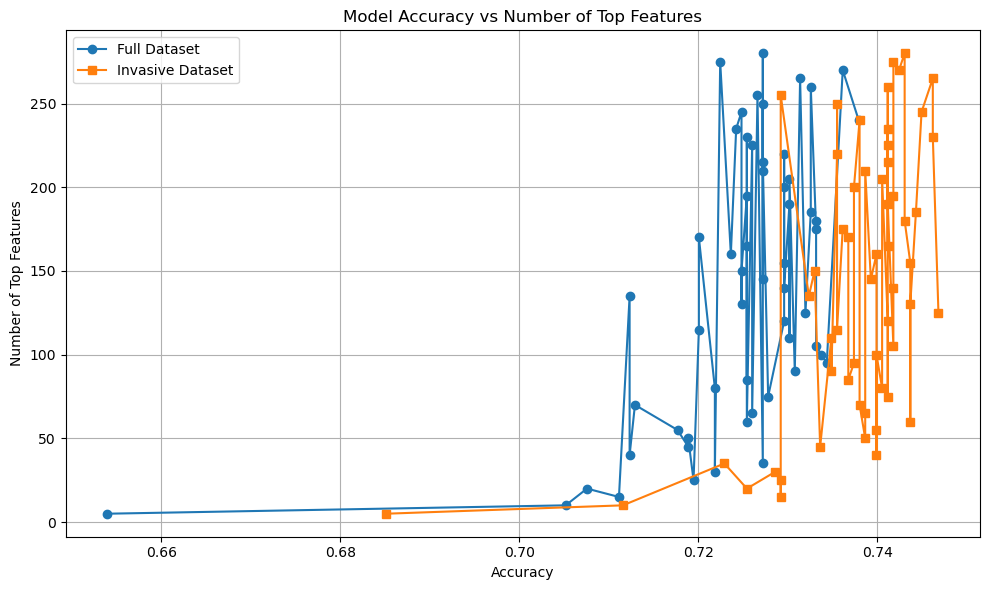

In [26]:
# Separate results for each dataset
full = results_df[results_df['Dataset'] == 'Full Dataset']
invasive = results_df[results_df['Dataset'] == 'Invasive']

plt.figure(figsize=(10, 6))
plt.plot(full['Accuracy'], full['Top_N_Features'], label='Full Dataset', marker='o')
plt.plot(invasive['Accuracy'], invasive['Top_N_Features'], label='Invasive Dataset', marker='s')

plt.ylabel('Number of Top Features')
plt.xlabel('Accuracy')
plt.title('Model Accuracy vs Number of Top Features')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Run the model with top 55 features

In [27]:
for dataset in datasets:
    name = dataset['name']
    print(f"\nRunning model for {name}...")

    # Get top 55 features for this dataset
    top_features = feature_rankings[name].head(55).index.tolist()

    # Slice train/test using only top features
    X_train_subset = dataset['X_train'][top_features]
    X_test_subset = dataset['X_test'][top_features]
    y_train = dataset['y_train']
    y_test = dataset['y_test']

    # Train model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_subset, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test_subset)
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Running model for Full Dataset...
              precision    recall  f1-score   support

           0       0.75      0.65      0.70       838
           1       0.69      0.79      0.74       841

    accuracy                           0.72      1679
   macro avg       0.72      0.72      0.72      1679
weighted avg       0.72      0.72      0.72      1679

Accuracy: 0.7177

Running model for Invasive...
              precision    recall  f1-score   support

           0       0.78      0.65      0.71       783
           1       0.71      0.82      0.76       805

    accuracy                           0.74      1588
   macro avg       0.75      0.74      0.74      1588
weighted avg       0.75      0.74      0.74      1588

Accuracy: 0.7399


Both datasets show good performance (74% accuracy) using the top 55 features. The model has a slight bias toward detecting class 1 (positive), likely prioritizing recall. F1-scores are balanced, indicating a reasonable trade-off between precision and recall.

#### Tune Hyperparameters

In [28]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

for dataset in datasets:
    name = dataset['name']
    print(f"\nTuning model for {name}...")

    # Get the top 55 features for this dataset
    top_features = feature_rankings[name].head(55).index.tolist()

    X_train = dataset['X_train'][top_features]
    y_train = dataset['y_train']
    X_test = dataset['X_test'][top_features]
    y_test = dataset['y_test']

    # Initialize model and perform random search
    rf = RandomForestClassifier(random_state=42)
    search = RandomizedSearchCV(
        rf, param_grid, n_iter=10, cv=3,
        scoring='accuracy', n_jobs=-1, verbose=1
    )
    search.fit(X_train, y_train)
    best_rf = search.best_estimator_

    # Evaluate on test set
    y_pred = best_rf.predict(X_test)
    print(f"Best Parameters for {name}: {search.best_params_}")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Tuning model for Full Dataset...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for Full Dataset: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}
              precision    recall  f1-score   support

           0       0.76      0.65      0.70       838
           1       0.69      0.80      0.74       841

    accuracy                           0.72      1679
   macro avg       0.73      0.72      0.72      1679
weighted avg       0.73      0.72      0.72      1679

Accuracy: 0.7236

Tuning model for Invasive...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for Invasive: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}
              precision    recall  f1-score   support

           0       0.78      0.64      0.70       783
           1       0.70      0.83      0.76       805

    accuracy      

Add Feature Interactions
- Try PCA if you suspect redundancy
- Normalize skewed features
- Bin high-cardinality continuous values
- Encode categorical features if not already done

In [29]:
# Try Feature Engineering or Dimensionality Reduction

In [30]:
# Try Ensemble or Stacking